In [1]:
#basic libraries
import h2o
import numpy as np
import pandas as pd
import re

#scikit-learn libraries
from sklearn.preprocessing import LabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

#h2o models and grid search
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators import H2OXGBoostEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.grid.grid_search import H2OGridSearch

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data/LoansTrainingSetV2.csv')

C:\Users\agust\AppData\Local\Temp\ipykernel_14228\403483046.py:1: DtypeWarning: Columns (10,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/LoansTrainingSetV2.csv')


In [3]:
df.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,6cf51492-02a2-423e-b93d-676f05b9ad53,7c202b37-2add-44e8-9aea-d5b119aea935,Loan Refused,12232,Short Term,7280.0,< 1 year,Rent,46643.0,Debt Consolidation,777.39,18.0,10.0,12,0,6762,7946,0.0,0.0
1,552e7ade-4292-4354-9ff9-c48031697d72,e7217b0a-07ac-47dd-b379-577b5a35b7c6,Loan Refused,25014,Long Term,7330.0,10+ years,Home Mortgage,81099.0,Debt Consolidation,892.09,26.7,NaN,14,0,35706,77961,0.0,0.0
2,9b5e32b3-8d76-4801-afc8-d729d5a2e6b9,0a62fc41-16c8-40b5-92ff-9e4b763ce714,Loan Refused,16117,Short Term,7240.0,9 years,Home Mortgage,60438.0,Home Improvements,1244.02,16.7,32.0,11,1,11275,14815,1.0,0.0
3,5419b7c7-ac11-4be2-a8a7-b131fb6d6dbe,30f36c59-5182-4482-8bbb-5b736849ae43,Loan Refused,11716,Short Term,7400.0,3 years,Rent,34171.0,Debt Consolidation,990.94,10.0,NaN,21,0,7009,43533,0.0,0.0
4,1450910f-9495-4fc9-afaf-9bdf4b9821df,70c26012-bba5-42c0-8dcb-75295ada31bb,Loan Refused,9789,Long Term,6860.0,10+ years,Home Mortgage,47003.0,Home Improvements,503.71,16.7,25.0,13,1,16913,19553,1.0,0.0


In [4]:
df.shape

(111105, 19)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111105 entries, 0 to 111104
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Loan ID                       111105 non-null  object 
 1   Customer ID                   111105 non-null  object 
 2   Loan Status                   111105 non-null  object 
 3   Current Loan Amount           111105 non-null  int64  
 4   Term                          111105 non-null  object 
 5   Credit Score                  89767 non-null   float64
 6   Years in current job          106412 non-null  object 
 7   Home Ownership                111105 non-null  object 
 8   Annual Income                 89767 non-null   float64
 9   Purpose                       111105 non-null  object 
 10  Monthly Debt                  111105 non-null  object 
 11  Years of Credit History       111105 non-null  float64
 12  Months since last delinquent  52102 non-null

The datatypes seems fine. However, I need to inspect Years in current job, Monthly Debt, and Maximum Open Credit column. From my point of view, they shouldn't be object.

In [6]:
df.describe()

,Current Loan Amount,Credit Score,Annual Income,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Bankruptcies,Tax Liens
count,1.111050e+05,89767.000000,8.976700e+04,111105.000000,52102.00000,111105.000000,111105.000000,1.111050e+05,110877.000000,111094.000000
mean,1.147739e+07,1075.662036,7.248528e+04,18.201012,34.90223,11.125044,0.168021,1.548308e+04,0.117662,0.029354
std,3.185533e+07,1473.879929,5.593131e+04,7.014530,21.97033,5.010288,0.484210,1.982133e+04,0.351423,0.260577
min,4.910000e+02,585.000000,4.033000e+03,3.600000,0.00000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,8.162000e+03,705.000000,4.468700e+04,13.500000,16.00000,8.000000,0.000000,5.905000e+03,0.000000,0.000000
50%,1.418300e+04,724.000000,6.175200e+04,16.900000,32.00000,10.000000,0.000000,1.102700e+04,0.000000,0.000000
75%,2.382200e+04,741.000000,8.688700e+04,21.700000,51.00000,14.000000,0.000000,1.933800e+04,0.000000,0.000000
max,1.000000e+08,7510.000000,8.713547e+06,70.500000,176.00000,76.000000,15.000000,1.730472e+06,7.000000,15.000000


In [7]:
df.isnull().sum()

Loan ID                             0
Customer ID                         0
Loan Status                         0
Current Loan Amount                 0
Term                                0
Credit Score                    21338
Years in current job             4693
Home Ownership                      0
Annual Income                   21338
Purpose                             0
Monthly Debt                        0
Years of Credit History             0
Months since last delinquent    59003
Number of Open Accounts             0
Number of Credit Problems           0
Current Credit Balance              0
Maximum Open Credit                 0
Bankruptcies                      228
Tax Liens                          11
dtype: int64

There are 6 columns with missing values. The column Months since last delinquent has the most missing values, and it might be problematic. It's followed by Credit Score and Annual Income. I need to see what the data looks like before deciding which strategy I should implement for data imputation.

# EDA

Before imputing the missing data, I will perform EDA to understand the data better. First of all, I will convert the column names into snake case to make it easier to call later.

I will start with the EDA for single variables.

In [8]:
def clean_columns(column_list):
    all_cols = column_list
    
    modified_list = []

    for item in all_cols:
        item = str(item).lower()
        modified_item = re.sub(r'[^a-zA-Z0-9]', '_', item)
        modified_list.append(modified_item)
    
    final_list = []
    
    for i in modified_list:
        cleaned_column_name = re.sub(r'_+', '_', i)
        final_list.append(cleaned_column_name)
    
    final_list = [col.strip('_') for col in final_list]
        
    return final_list

In [9]:
df.columns = clean_columns(df.columns.tolist())

In [10]:
df.head()

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
0,6cf51492-02a2-423e-b93d-676f05b9ad53,7c202b37-2add-44e8-9aea-d5b119aea935,Loan Refused,12232,Short Term,7280.0,< 1 year,Rent,46643.0,Debt Consolidation,777.39,18.0,10.0,12,0,6762,7946,0.0,0.0
1,552e7ade-4292-4354-9ff9-c48031697d72,e7217b0a-07ac-47dd-b379-577b5a35b7c6,Loan Refused,25014,Long Term,7330.0,10+ years,Home Mortgage,81099.0,Debt Consolidation,892.09,26.7,NaN,14,0,35706,77961,0.0,0.0
2,9b5e32b3-8d76-4801-afc8-d729d5a2e6b9,0a62fc41-16c8-40b5-92ff-9e4b763ce714,Loan Refused,16117,Short Term,7240.0,9 years,Home Mortgage,60438.0,Home Improvements,1244.02,16.7,32.0,11,1,11275,14815,1.0,0.0
3,5419b7c7-ac11-4be2-a8a7-b131fb6d6dbe,30f36c59-5182-4482-8bbb-5b736849ae43,Loan Refused,11716,Short Term,7400.0,3 years,Rent,34171.0,Debt Consolidation,990.94,10.0,NaN,21,0,7009,43533,0.0,0.0
4,1450910f-9495-4fc9-afaf-9bdf4b9821df,70c26012-bba5-42c0-8dcb-75295ada31bb,Loan Refused,9789,Long Term,6860.0,10+ years,Home Mortgage,47003.0,Home Improvements,503.71,16.7,25.0,13,1,16913,19553,1.0,0.0


In [11]:
def create_bar_chart(df,col,rotation=0):
    value_counts_series = df[col].value_counts()

    # Create a bar chart using Seaborn
    sns.barplot(x=value_counts_series.index, y=value_counts_series.values)

    # Add labels and title
    plt.xlabel(col.replace('_',' ').title())
    plt.ylabel('Count')
    plt.title('Distribution of ' + col.replace('_',' ').title())

    plt.xticks(rotation=rotation)

    # Show the plot
    plt.show();

In [12]:
def create_histogram(df,col):
    plt.hist(df[col])
    plt.title('Histogram of ' + col.replace('_',' ').title())
    plt.show()

### Loan Status
I will check whether there are class imbalances in this column.

In [13]:
df.loan_status.value_counts()

loan_status
Loan Given      85934
Loan Refused    25171
Name: count, dtype: int64

In [14]:
df.loan_status.value_counts().index.name

'loan_status'

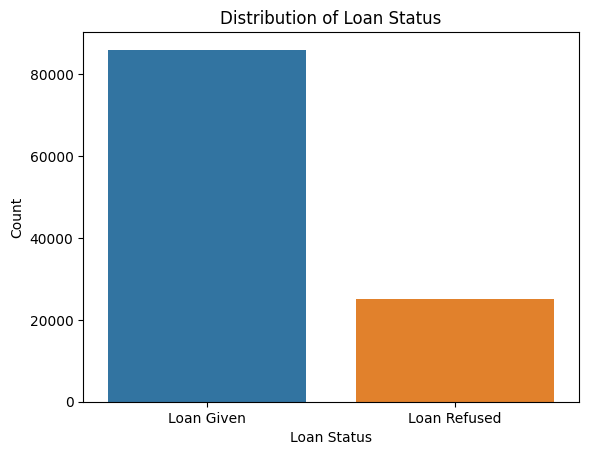

In [15]:
create_bar_chart(df,'loan_status')

According to the bar chart, there is a class imbalance in the loan status column where there are significantly more loan given compared to loan refused.

Next, I'll create a histogram of the current loan amount column to understand the data distribution.

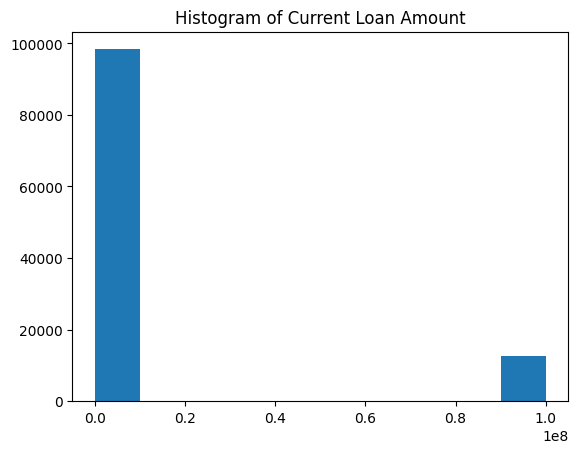

In [16]:
create_histogram(df,'current_loan_amount')

There are extreme values in the histogram. The values are:

In [17]:
df[df.current_loan_amount == df.current_loan_amount.max()].head()

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
5042,bac918fa-35e0-40a2-af65-58b456a742e7,c96da120-30d2-4acd-9740-e4d280f4bfcb,Loan Given,99999999,Short Term,739.0,3 years,Home Mortgage,60012.0,Home Improvements,1295.26,16.6,33.0,16,0,427,8542,0.0,0.0
5043,bb983383-0aa0-4d13-9b7f-05f694672374,d602647a-0820-4025-b93d-9f962f958acf,Loan Given,99999999,Short Term,704.0,9 years,Rent,54802.0,Debt Consolidation,1114.31,16.9,30.0,12,0,4716,5822,0.0,0.0
5044,0c7fcf5e-ec4a-46d5-8175-15c846df7c74,a709e893-b6b6-49ed-b775-bdef1155c78d,Loan Given,99999999,Short Term,751.0,5 years,Rent,35693.0,Debt Consolidation,626.12,11.0,NaN,7,0,742,9166,0.0,0.0
5045,878c4189-bd53-4836-a16d-203519034758,64fa8876-80fa-4a69-b16b-144a8ecfb14a,Loan Given,99999999,Short Term,735.0,NaN,Home Mortgage,33884.0,Debt Consolidation,683.34,18.9,10.0,12,0,10835,18028,0.0,0.0
5046,193ac878-4d50-4be0-995b-20896ebc9ad8,02a4bc6d-db02-406b-9bf6-8e0dd42782eb,Loan Given,99999999,Short Term,745.0,3 years,Own Home,103343.0,Debt Consolidation,1300.41,14.1,NaN,14,0,22746,42835,0.0,0.0


In [18]:
mean_extreme_values = df[df.current_loan_amount == df.current_loan_amount.max()].current_loan_amount.mean()
print(f"The average of the extreme values found in the dataframe is {mean_extreme_values}")

The average of the extreme values found in the dataframe is 99999999.0


The values off all the extreme values are 99999999.0. This indicates that there are errors in inputting the data. I will need to deal with this later.

Next, I will create the bar chart of the loan term.

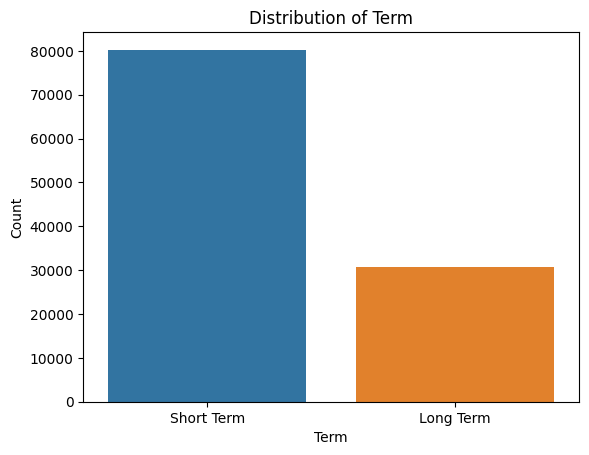

In [19]:
create_bar_chart(df,'term')

Again, there is a class imbalance problem here. But as this is a feature, I will later do a one-hot-encode for this column.

Next, onto the credit score histogram.

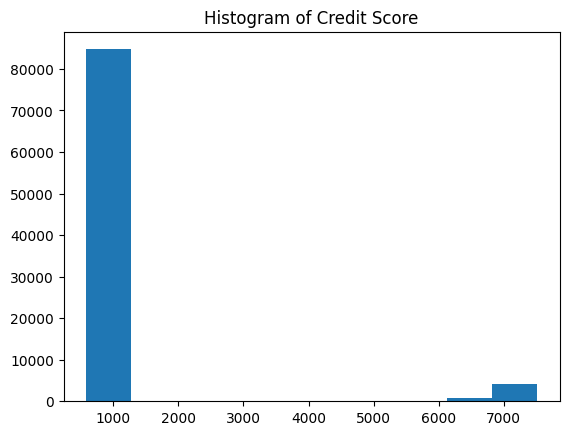

In [20]:
create_histogram(df,'credit_score')

As we can see, there are values that exceed the maximum credit score according to FICO (850). Although there is another method of scoring credit which goes up to 900, I will use FICO as the most common one. I will take a look at the data description where the credit score exceeds 850.

In [21]:
df[df.credit_score>850].credit_score.describe()

count    5042.000000
mean     7109.071797
std       306.060537
min      5850.000000
25%      6950.000000
50%      7190.000000
75%      7350.000000
max      7510.000000
Name: credit_score, dtype: float64

The minimum value is 5850 and the maximum value is 7510. Again, this has to be beacuse of errors in inputting the data. I will divide this score by 10, assuming that the errors happened because of inputting an extra 0 in each row.

Next, I will take a look at the distribution of years in current job.

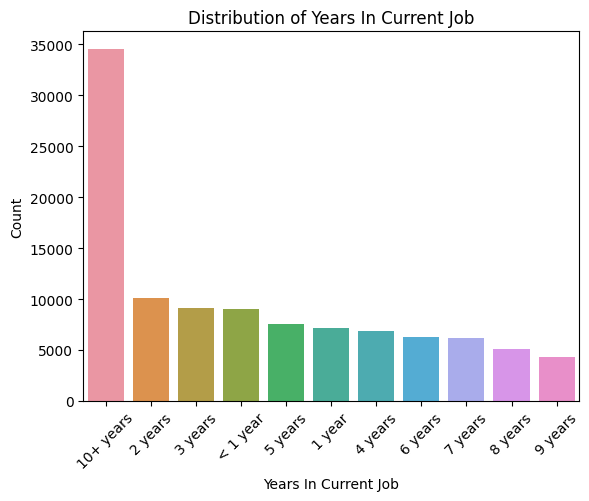

In [22]:
create_bar_chart(df,'years_in_current_job', rotation=45)

Most of the people applying for loan have work 10+ years in their respective companies. The data type is string, because there are special characters and the word 'year(s)'. I will map this into numbers, but treat it as categorical data. 

Next, I will look at the distribution of home ownership.

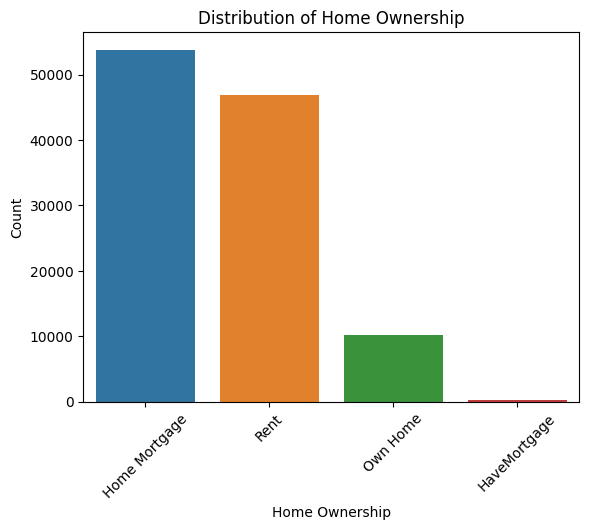

In [23]:
create_bar_chart(df,'home_ownership', rotation=45)

I think the values "Home Mortgage" and "HaveMortgage" is the same. I will have to change it accordingly in the data cleaning phase.

Next, I will examine the distribution of annual income.

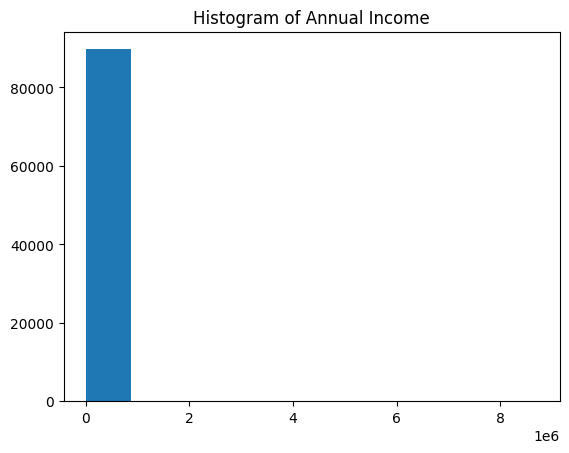

In [24]:
create_histogram(df,'annual_income')

There seems to be extreme values in the data. I will check whether it's an error or not.

In [25]:
df[df.annual_income == df.annual_income.max()]

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
3669,6dfd2f9c-b796-4cb3-8f71-04d6ae8a8f92,ceee183a-9b02-4b82-ae53-14ccd5f785fd,Loan Refused,8006,Short Term,7250.0,10+ years,Home Mortgage,8713547.0,Debt Consolidation,798.74,16.0,NaN,11,0,16462,30429,0.0,0.0


I'm not really sure whether this is an error or not. I would say it's possible for someone to have an annual income of USD 8M+ (assuming that the annual income is in USD). And since the purpose of the loan is debt consolidation, it's probable that this person uses debt to finance the business. Therefore, I will not change it and assume that this data is correct.

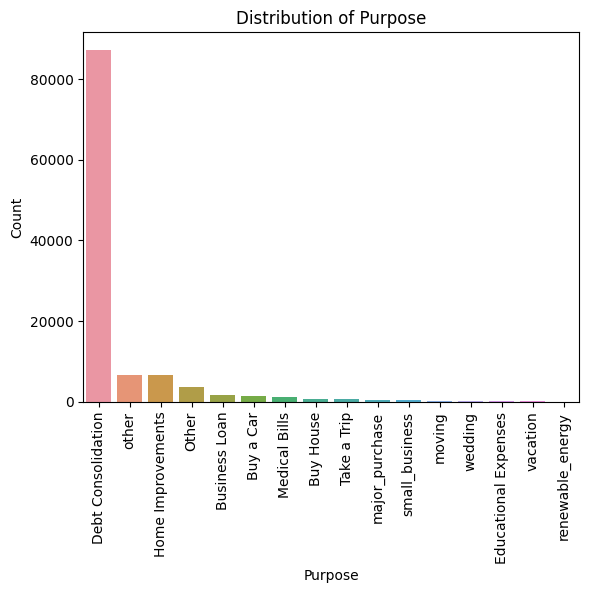

In [26]:
create_bar_chart(df,'purpose', rotation=90)

The majority of people applied for loans with the purpose of debt consolidation. One thing to note here, the data is written using 2 styles: Title and Snake Case. I will convert all the values in columns with string values into snake case (all lowercase), especially for the ones I need to do one-hot-encoding. Looking closely, if I let the values to be as they are, there will be problem such as "other" and "Other" being treated differently while it's obviously the same.

Before moving on the the monthly_debt, I need to check why the column has object values instead of float (as I mentioned before).

In [27]:
data_list = df.monthly_debt.tolist()
data_list_numeric = pd.to_numeric(data_list, errors='coerce')
non_numeric_indices = [index for index, item in enumerate(data_list_numeric) if pd.isna(item)]
for idx in non_numeric_indices:
    print(data_list[idx])

$1051.41
$157.15
$944.7
$481.34
$1838.98
$471.6


Apparently, the monthly_debt column has a dollar symbol on some of the values. Before proceeding to build the histogram, I need to fix this and change the datatype into float.

In [28]:
data_float = []
for i in data_list:
    try:
        flt_data = float(i)
    except:
        flt_data = float(i.strip().replace('$',''))
    data_float.append(flt_data)

In [29]:
data_list_numeric = pd.to_numeric(data_float, errors='coerce')
non_numeric_indices = [index for index, item in enumerate(data_float) if pd.isna(item)]
print(f"There are {len(non_numeric_indices)} non-numeric data")

There are 0 non-numeric data


In [30]:
df['monthly_debt'] = data_float

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111105 entries, 0 to 111104
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   loan_id                       111105 non-null  object 
 1   customer_id                   111105 non-null  object 
 2   loan_status                   111105 non-null  object 
 3   current_loan_amount           111105 non-null  int64  
 4   term                          111105 non-null  object 
 5   credit_score                  89767 non-null   float64
 6   years_in_current_job          106412 non-null  object 
 7   home_ownership                111105 non-null  object 
 8   annual_income                 89767 non-null   float64
 9   purpose                       111105 non-null  object 
 10  monthly_debt                  111105 non-null  float64
 11  years_of_credit_history       111105 non-null  float64
 12  months_since_last_delinquent  52102 non-null

Now, the monthly_debt has the correct datatype. I will plot the histogram.

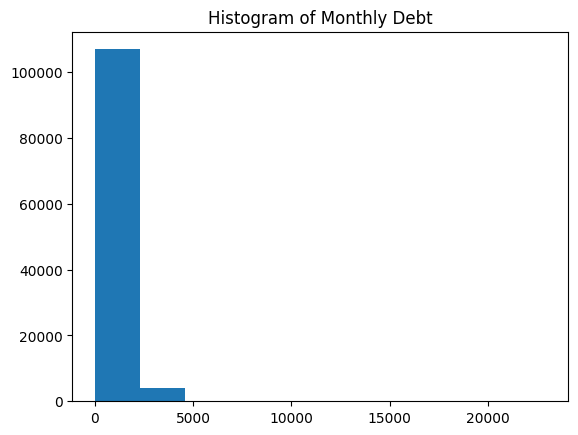

In [32]:
create_histogram(df,'monthly_debt')

There seems to be extreme values as well in this data. Let's check the data description of people with monthly debt larger than the 75% quantile.

In [33]:
df[df.monthly_debt > df.monthly_debt.describe()['75%']].monthly_debt.describe()

count    27775.000000
mean      1821.517244
std        625.113477
min       1262.720000
25%       1416.895000
50%       1636.520000
75%       2011.140000
max      22939.120000
Name: monthly_debt, dtype: float64

The extreme values are still present. Let's check whether it's still present if the monthly debt is larger than 10000.

In [34]:
df[df.monthly_debt >10000].monthly_debt

4010     10831.65
18580    12055.68
79752    22939.12
89940    12055.68
Name: monthly_debt, dtype: float64

Apparently, the extreme values are just present without errors. It's possible that some people have high monthly debt to be paid. Therefore, I won't do anything to this column as well.

In [35]:
df.head()

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
0,6cf51492-02a2-423e-b93d-676f05b9ad53,7c202b37-2add-44e8-9aea-d5b119aea935,Loan Refused,12232,Short Term,7280.0,< 1 year,Rent,46643.0,Debt Consolidation,777.39,18.0,10.0,12,0,6762,7946,0.0,0.0
1,552e7ade-4292-4354-9ff9-c48031697d72,e7217b0a-07ac-47dd-b379-577b5a35b7c6,Loan Refused,25014,Long Term,7330.0,10+ years,Home Mortgage,81099.0,Debt Consolidation,892.09,26.7,NaN,14,0,35706,77961,0.0,0.0
2,9b5e32b3-8d76-4801-afc8-d729d5a2e6b9,0a62fc41-16c8-40b5-92ff-9e4b763ce714,Loan Refused,16117,Short Term,7240.0,9 years,Home Mortgage,60438.0,Home Improvements,1244.02,16.7,32.0,11,1,11275,14815,1.0,0.0
3,5419b7c7-ac11-4be2-a8a7-b131fb6d6dbe,30f36c59-5182-4482-8bbb-5b736849ae43,Loan Refused,11716,Short Term,7400.0,3 years,Rent,34171.0,Debt Consolidation,990.94,10.0,NaN,21,0,7009,43533,0.0,0.0
4,1450910f-9495-4fc9-afaf-9bdf4b9821df,70c26012-bba5-42c0-8dcb-75295ada31bb,Loan Refused,9789,Long Term,6860.0,10+ years,Home Mortgage,47003.0,Home Improvements,503.71,16.7,25.0,13,1,16913,19553,1.0,0.0


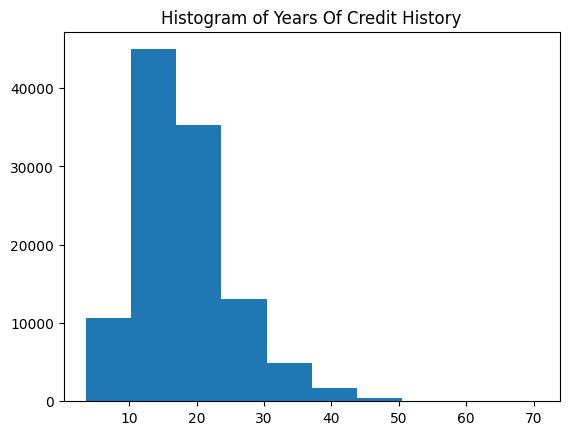

In [36]:
create_histogram(df,'years_of_credit_history')

The distribution is skewed to the right. The number of people with 10 to about 18 years in credit history is the most compared to the other bins.

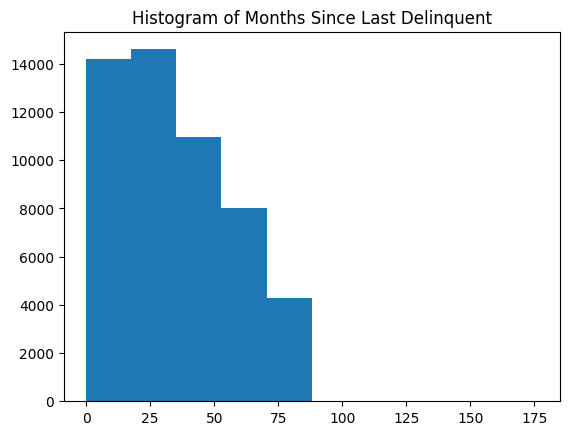

In [37]:
create_histogram(df,'months_since_last_delinquent')

In [38]:
df.months_since_last_delinquent.isnull().sum()/df.shape[0]

0.531056208091445

In [39]:
df[df.months_since_last_delinquent == df.months_since_last_delinquent.max()]

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
83368,b7a27936-8fa8-4b9e-a35f-3a2b57ee725e,8480986e-847d-4523-9e04-21aff3713190,Loan Given,7928,Short Term,715.0,10+ years,Own Home,55193.0,Debt Consolidation,1044.06,23.8,176.0,13,0,19174,20978,0.0,0.0
107593,b7a27936-8fa8-4b9e-a35f-3a2b57ee725e,8480986e-847d-4523-9e04-21aff3713190,Loan Given,7928,Short Term,715.0,10+ years,Own Home,55193.0,Debt Consolidation,1044.06,23.8,176.0,13,0,19174,20978,0.0,0.0


Delinquency in loan refers to when someone is late in paying debt. Based on the histogram, there are extreme values as well. And the highest frequency is from about 23 to 27 months, followed by 0 to about 22 months. There are more than 53% missing data here. The data imputation for this column will be problematic. Before deciding on the imputation method, I will examine the relationship between delinquency and loan status, and delinquency and number of credit problem.

When examining the extreme values, I found out that there are duplicates in the dataset. I will deal with it during the data cleaning phase.

Next, I will examine the number of open accounts.

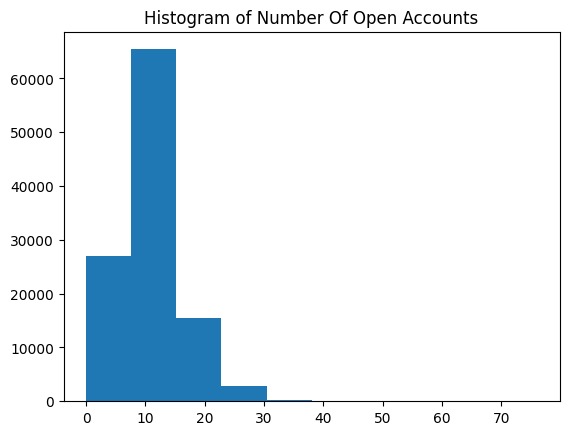

In [40]:
create_histogram(df,'number_of_open_accounts')

In [41]:
df[df.number_of_open_accounts == df.number_of_open_accounts.max()]

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
2249,08dab131-9db3-4184-a32a-e12e48fd5d6c,907c2a89-76f8-4089-9a47-d410bb885339,Loan Refused,18755,Long Term,6700.0,7 years,Rent,46912.0,Debt Consolidation,1032.06,27.4,NaN,76,0,22111,28131,0.0,0.0
54290,f4e0a453-a5ec-4011-9513-9d203ffe8e3c,3e62a9e2-a61b-472d-8e56-234e30061580,Loan Refused,20426,Short Term,708.0,5 years,Home Mortgage,122556.0,Debt Consolidation,2195.80,15.7,NaN,76,0,40606,121575,0.0,0.0


The column account here is not clear. It can refer to the number of bank accounts or loan accounts opened. Most people have about 9 to 15 accounts opened. The distribution is also skewed to the right.

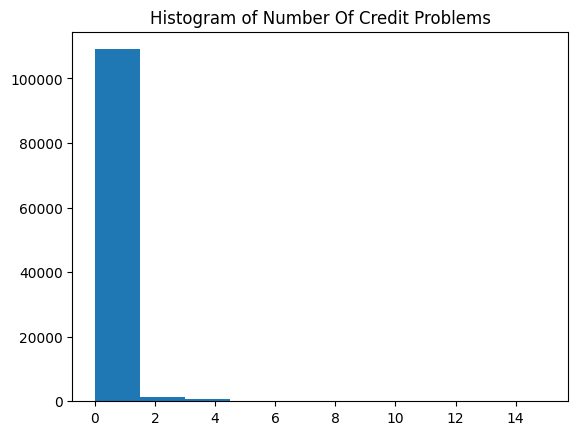

In [42]:
create_histogram(df, 'number_of_credit_problems')

Most people don't have problems in their credit. I will examine the relationship between this variable with loan status later.

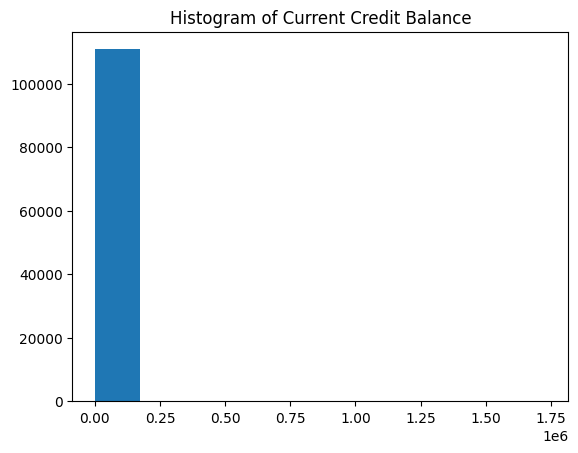

In [43]:
create_histogram(df, 'current_credit_balance')

Credit balance in loans often refers to whether a borrower overpaid their loans. Since there are no negative numbers, all of the people either paid the exact loan amount or overpaid their loans.

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111105 entries, 0 to 111104
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   loan_id                       111105 non-null  object 
 1   customer_id                   111105 non-null  object 
 2   loan_status                   111105 non-null  object 
 3   current_loan_amount           111105 non-null  int64  
 4   term                          111105 non-null  object 
 5   credit_score                  89767 non-null   float64
 6   years_in_current_job          106412 non-null  object 
 7   home_ownership                111105 non-null  object 
 8   annual_income                 89767 non-null   float64
 9   purpose                       111105 non-null  object 
 10  monthly_debt                  111105 non-null  float64
 11  years_of_credit_history       111105 non-null  float64
 12  months_since_last_delinquent  52102 non-null

The maximum open credit column has object as datatype. It should be numeric. I will see what's wrong with this column.

In [45]:
data_list = df.maximum_open_credit.tolist()
data_list_numeric = pd.to_numeric(data_list, errors='coerce')
non_numeric_indices = [index for index, item in enumerate(data_list_numeric) if pd.isna(item)]
for idx in non_numeric_indices:
    print(data_list[idx])

#VALUE!
#VALUE!


In [46]:
df[df.maximum_open_credit == '#VALUE!']

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
4928,e42ae1f7-74b5-46d7-95ce-46a88918ba12,a679ed55-963a-4de6-8be0-4364eb601b6f,Loan Refused,2052,Short Term,7030.0,10+ years,Rent,95105.0,Debt Consolidation,1910.02,22.4,37.0,9,0,0,#VALUE!,0.0,0.0
37355,b798f46b-e27b-4823-af83-294b1ffc3490,f61890c5-e264-4b0f-a047-9cfa03b9d182,Loan Refused,1470,Short Term,NaN,2 years,Rent,NaN,Debt Consolidation,506.34,15.3,26.0,3,0,0,#VALUE!,0.0,0.0


Clearly, there are errors in inputting the data. I will replace these with NaN values since I don't know what the actual values are.

In [47]:
df['maximum_open_credit'] = df.maximum_open_credit.replace('#VALUE!', np.nan, regex=True)
df['maximum_open_credit'] = df['maximum_open_credit'].astype('float')

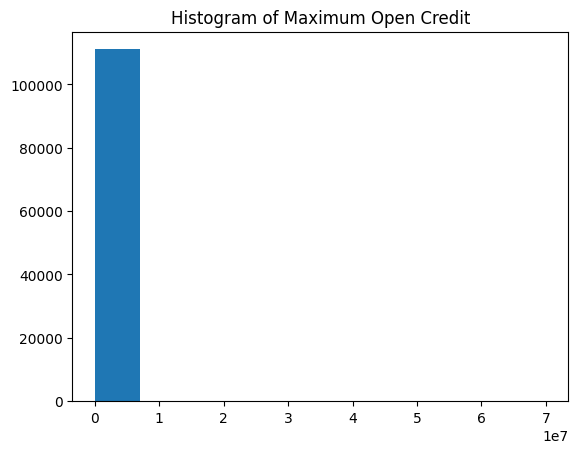

In [48]:
create_histogram(df,'maximum_open_credit')

Again, there are extreme values present. I will examine that.

In [49]:
df[df.maximum_open_credit == df.maximum_open_credit.max()]

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
58914,f02dc06f-30f4-4b1d-ba58-156c2f3bd33d,a5c22bae-59c4-4a6c-8f04-628a4dadef57,Loan Given,34419,Long Term,729.0,< 1 year,Home Mortgage,172095.0,Debt Consolidation,2007.78,19.8,NaN,16,0,139976,69988086.0,0.0,0.0


In [50]:
df.maximum_open_credit.describe()

count    1.111030e+05
mean     3.438660e+04
std      3.643059e+05
min      0.000000e+00
25%      1.241700e+04
50%      2.124300e+04
75%      3.558400e+04
max      6.998809e+07
Name: maximum_open_credit, dtype: float64

In [51]:
df['maximum_open_credit'].quantile([0.5,0.75,0.95,0.99,1])

0.50       21243.00
0.75       35584.00
0.95       74538.70
0.99      164623.96
1.00    69988086.00
Name: maximum_open_credit, dtype: float64

There is only one extreme value, and the gap between the 99th quantile and the 100th quantile is huge. I would assume that this is an error in inputting the data. I will change the highest number to NaN for now.

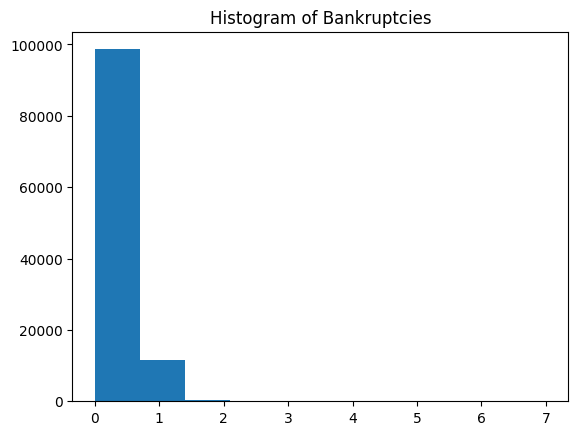

In [52]:
create_histogram(df, 'bankruptcies')

In [53]:
df.bankruptcies.value_counts()

bankruptcies
0.0    98648
1.0    11613
2.0      468
3.0      110
4.0       27
5.0        8
6.0        2
7.0        1
Name: count, dtype: int64

The number of people who declared bankruptcies for more than 1 times is extremely low, which is logical. Most haven't declared bankruptcies or at most 1 time. 

Next, onto tax liens. A tax lien is some sort of a legal claim by government to people who have tax debt.

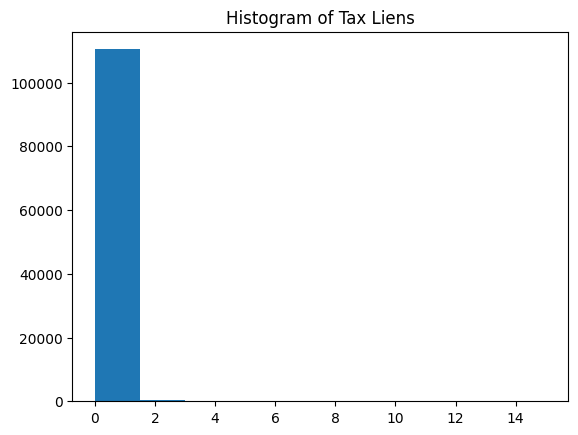

In [54]:
create_histogram(df, 'tax_liens')

Again, most people has 0-1 tax liens indicating that they don't have tax debt.

The single variable analysis is finished. The takeaways from the EDA is:
1. Examining duplicated data
2. Dealing with the extreme values in the current_loan_amount column
3. Fix the values in the credit_score which are more than 850
4. Map the values in the years_in_current_job column to numbers, but change the type into categorical
5. Change the value HaveMortage to Home Mortgage in the home_ownership column
6. Convert all the string values in all of the column into snake case, all lowercase.
7. Impute the missing values in the months_since_last_delinquent column
8. Change the extreme value in the maximum_open_credit column into NaN value, and impute it later
9. Impute the missing values in the rest of the columns

Now that the single variable analysis is finished, I will move on to the relationship between 2 or more variables. Hpwever, I will do some data cleaning first to make sure that the plots generated will be more readable. This data cleaning part will be everything mentioned above except for data imputation.

In [55]:
df.head()

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
0,6cf51492-02a2-423e-b93d-676f05b9ad53,7c202b37-2add-44e8-9aea-d5b119aea935,Loan Refused,12232,Short Term,7280.0,< 1 year,Rent,46643.0,Debt Consolidation,777.39,18.0,10.0,12,0,6762,7946.0,0.0,0.0
1,552e7ade-4292-4354-9ff9-c48031697d72,e7217b0a-07ac-47dd-b379-577b5a35b7c6,Loan Refused,25014,Long Term,7330.0,10+ years,Home Mortgage,81099.0,Debt Consolidation,892.09,26.7,NaN,14,0,35706,77961.0,0.0,0.0
2,9b5e32b3-8d76-4801-afc8-d729d5a2e6b9,0a62fc41-16c8-40b5-92ff-9e4b763ce714,Loan Refused,16117,Short Term,7240.0,9 years,Home Mortgage,60438.0,Home Improvements,1244.02,16.7,32.0,11,1,11275,14815.0,1.0,0.0
3,5419b7c7-ac11-4be2-a8a7-b131fb6d6dbe,30f36c59-5182-4482-8bbb-5b736849ae43,Loan Refused,11716,Short Term,7400.0,3 years,Rent,34171.0,Debt Consolidation,990.94,10.0,NaN,21,0,7009,43533.0,0.0,0.0
4,1450910f-9495-4fc9-afaf-9bdf4b9821df,70c26012-bba5-42c0-8dcb-75295ada31bb,Loan Refused,9789,Long Term,6860.0,10+ years,Home Mortgage,47003.0,Home Improvements,503.71,16.7,25.0,13,1,16913,19553.0,1.0,0.0


## Data Cleaning
### 1. Examining duplicates

The crucial columns that cannot have duplicates is Loan ID. If it has duplicates, it indicates double input because ID needs to be unique. Furthermore, for every Loan ID, there can only be one customer. If there are 2 or more customers with the same Loan ID, it indicates that there are errors in inputting the data. These needs to be dropped. 

In [56]:
#dropping all duplicate columns
df.drop_duplicates(inplace = True)

In [57]:
df.shape

(98579, 19)

In [58]:
duplicate_rows = df[df.duplicated(subset=['loan_id'], keep=False)]
duplicate_rows_sorted = duplicate_rows.sort_values(by='loan_id')

In [59]:
duplicate_rows_sorted.head()

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
97429,0004f37b-5859-40f6-98d0-367aa3b3f3f1,f662b062-5fa5-463d-b5c0-4e36d09fcab1,Loan Given,13719,Short Term,724.0,1 year,Own Home,34297.0,Home Improvements,777.38,13.6,2.0,12,0,6720,53335.0,0.0,0.0
32050,0004f37b-5859-40f6-98d0-367aa3b3f3f1,f662b062-5fa5-463d-b5c0-4e36d09fcab1,Loan Given,13719,Short Term,NaN,1 year,Own Home,NaN,Home Improvements,777.38,13.6,2.0,12,0,6720,53335.0,0.0,0.0
32216,00069ff1-a877-4d35-81be-7cd359b99956,ee3c27f2-766a-499c-9a96-d17c4d2faa16,Loan Given,1433,Short Term,NaN,10+ years,Home Mortgage,NaN,Home Improvements,2627.76,15.1,5.0,22,0,27706,49563.0,0.0,0.0
97876,00069ff1-a877-4d35-81be-7cd359b99956,ee3c27f2-766a-499c-9a96-d17c4d2faa16,Loan Given,1433,Short Term,716.0,10+ years,Home Mortgage,108735.0,Home Improvements,2627.76,15.1,5.0,22,0,27706,49563.0,0.0,0.0
96169,000dbdf1-3926-4676-bb4f-fe40c242a46e,5165c688-1669-43e9-88b5-db212c72655c,Loan Given,34185,Long Term,717.0,3 years,Home Mortgage,88880.0,Debt Consolidation,1881.29,25.9,NaN,20,0,37507,50961.0,0.0,0.0


In [60]:
duplicate_rows.shape

(19342, 19)

In [61]:
#checking whether there are double customer_ids for every loan_id
count_different_customer_ids = duplicate_rows_sorted.groupby('loan_id')['customer_id'].nunique()
count_different_customer_ids = count_different_customer_ids[count_different_customer_ids > 1]
print(f'There are {len(count_different_customer_ids)} duplicated customers for every loan_id')

There are 0 duplicated customers for every loan_id


There are no duplicated customers for every loan_id. Therefore, I need to just group the loan_id and take the non-null values and non-extreme values. For example, the rows below:

In [62]:
df[df['loan_id'] == '000ea0cb-8d0e-4284-b8c8-444ffbbe4caf']

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
11541,000ea0cb-8d0e-4284-b8c8-444ffbbe4caf,db069b01-22c0-4b77-8b0a-b5704a0fd451,Loan Given,99999999,Short Term,715.0,10+ years,Rent,86437.0,Debt Consolidation,2204.13,18.0,NaN,22,0,21135,34366.0,0.0,0.0
108034,000ea0cb-8d0e-4284-b8c8-444ffbbe4caf,db069b01-22c0-4b77-8b0a-b5704a0fd451,Loan Given,21075,Short Term,715.0,10+ years,Rent,86437.0,Debt Consolidation,2204.13,18.0,NaN,22,0,21135,34366.0,0.0,0.0


the correct current_loan_amount should be 21075 instead of 99999999.

In [63]:
def handle_value(values):
    non_nan_values = [value for value in values if not pd.isna(value)]
    if any(isinstance(value, str) for value in non_nan_values):
        return non_nan_values[0]  # Return the first non-NaN string value
    else:
        non_extreme_values = [value for value in non_nan_values if value != 99999999]
        return non_extreme_values[0] if non_extreme_values else np.nan

In [64]:
df_agg = df.groupby('loan_id').agg(handle_value).reset_index()

In [65]:
df_agg[df_agg['loan_id'].duplicated()]

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens


In [66]:
df_agg[df_agg.duplicated()]

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens


In [67]:
df_agg.shape

(88908, 19)

### 2. Dealing with the extreme values in the current_loan_amount column

In [68]:
df_agg[df_agg.current_loan_amount == df_agg.current_loan_amount.max()]

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
27925,4fed402f-4298-4f5c-8d30-05b1f1819c00,84be9ce6-bf8d-47ee-829c-65b989433419,Loan Given,35875.0,Long Term,672.0,10+ years,Rent,92250.0,Debt Consolidation,1537.50,8.5,NaN,11,0,51132,69948.0,0.0,0.0
41456,770ca5a2-3b53-4c8c-a238-55cf72f66b82,e2615a86-9f65-43dd-88f2-e283bb99b7f4,Loan Refused,35875.0,Short Term,NaN,2 years,Home Mortgage,NaN,Debt Consolidation,908.84,21.0,NaN,8,0,21202,34872.0,0.0,0.0
63942,b7923e12-395b-49d6-97ee-ca0ed25b65c2,5c167711-571f-4dc9-b74c-2a53edca449a,Loan Given,35875.0,Short Term,721.0,6 years,Home Mortgage,423920.0,Debt Consolidation,6005.53,31.4,2.0,21,0,96113,109344.0,0.0,0.0


Apparently, dropping the duplicates also fix the extreme values in the current_loan_amount column.

### 3. Fix the values in the credit_score which are more than 850

In [69]:
df_agg.credit_score.describe()

count    72819.000000
mean      1163.058391
std       1623.983807
min        585.000000
25%        711.000000
50%        731.000000
75%        743.000000
max       7510.000000
Name: credit_score, dtype: float64

In [70]:
df_agg.loc[df_agg['credit_score'] > 850, 'credit_score'] = df_agg.loc[df_agg['credit_score'] > 850, 'credit_score'] / 10

In [71]:
print(f"The maximum number of credit score is now {df_agg.credit_score.max()}") 

The maximum number of credit score is now 751.0


### 4. Map the values in the years_in_current_job column to numbers, but change the type into categorical

In [72]:
mapping = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}

df_agg['years_in_current_job'] = df_agg['years_in_current_job'].map(mapping)

In [73]:
df_agg['years_in_current_job'] = df_agg.years_in_current_job.astype('category')

In [74]:
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88908 entries, 0 to 88907
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   loan_id                       88908 non-null  object  
 1   customer_id                   88908 non-null  object  
 2   loan_status                   88908 non-null  object  
 3   current_loan_amount           80592 non-null  float64 
 4   term                          88908 non-null  object  
 5   credit_score                  72819 non-null  float64 
 6   years_in_current_job          85091 non-null  category
 7   home_ownership                88908 non-null  object  
 8   annual_income                 72819 non-null  float64 
 9   purpose                       88908 non-null  object  
 10  monthly_debt                  88908 non-null  float64 
 11  years_of_credit_history       88908 non-null  float64 
 12  months_since_last_delinquent  40402 non-null  

### 5. Change the value HaveMortage to Home Mortgage in the home_ownership column

In [75]:
df_agg[df_agg['home_ownership'] == 'HaveMortgage'].head()

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
72,003665f5-adff-4fbb-903c-14d022fa6a08,80c0ee25-ec87-4e1f-aefc-e5bbd679cef1,Loan Given,1986.0,Short Term,719.0,9.0,HaveMortgage,35741.0,Take a Trip,452.72,11.0,69.0,5,5,856,7924.0,1.0,4.0
91,00434fa8-4473-4fde-9116-5fa02bbb46d4,f5f39047-dadd-4a0b-8016-d77ad2107c5d,Loan Given,NaN,Short Term,740.0,7.0,HaveMortgage,39076.0,Take a Trip,729.42,22.6,NaN,13,0,22151,24917.0,0.0,0.0
779,024bf769-1d1b-4af9-895e-e96aa07e9e14,37886523-ce0a-47bc-ae79-2e96f10bfd96,Loan Refused,975.0,Short Term,694.0,10.0,HaveMortgage,59599.0,Take a Trip,1157.22,27.2,3.0,12,0,17869,25859.0,0.0,0.0
1096,0330fe14-af97-41f9-a564-6ec542655a26,c90c0665-80a3-4705-b9db-5e325297fe2c,Loan Given,9093.0,Long Term,NaN,3.0,HaveMortgage,NaN,Take a Trip,1401.29,23.4,NaN,10,0,4593,6666.0,0.0,0.0
1771,0527b14a-1f6f-44fa-84e1-2e29a4f2a76d,8080d5ed-d14a-4d49-88a8-0071eaa9de68,Loan Given,10163.0,Short Term,705.0,7.0,HaveMortgage,66560.0,Take a Trip,904.11,9.5,NaN,9,0,4079,4404.0,0.0,0.0


In [76]:
df_agg['home_ownership'] = df_agg['home_ownership'].replace('HaveMortgage', 'Home Mortgage')

In [77]:
df_agg.home_ownership.value_counts()

home_ownership
Home Mortgage    43439
Rent             37394
Own Home          8075
Name: count, dtype: int64

### 6. Convert all the string values in all of the column into snake case, all lowercase

In [78]:
def has_non_ascii(s):
    for char in s:
        if ord(char) > 127:
            return True
    return False

In [79]:
df_agg = df_agg.applymap(lambda x: x if not isinstance(x, str) or not has_non_ascii(x) else x.encode('ascii', 'ignore').decode('ascii'))

In [80]:
categorical_cols = ['loan_status', 'term', 'home_ownership', 'purpose']

In [81]:
for col in categorical_cols:
    df_agg[col] = clean_columns(df_agg[col].tolist())

In [82]:
df_agg.head()

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
0,0000757f-a121-41ed-b17b-162e76647c1f,dde79588-12f0-4811-bab0-e2b07f633fcd,loan_given,11731.0,short_term,746.0,4.0,rent,50025.0,debt_consolidation,355.18,11.5,NaN,12,0,17391,37081.0,0.0,0.0
1,0000afa6-8902-4f8f-b870-25a8fdad0aeb,e49c1a82-a0f7-45e8-9f46-2f75c43f9fbc,loan_refused,24613.0,long_term,NaN,6.0,rent,NaN,business_loan,542.29,17.6,73.0,7,0,14123,16954.0,0.0,0.0
2,00020fb0-6b8a-4b3a-8c72-9c4c847e8cb6,c9decd06-16f7-44c3-b007-8776f2a9233d,loan_given,NaN,short_term,742.0,3.0,home_mortgage,64760.0,debt_consolidation,582.84,26.8,NaN,11,0,8880,22711.0,0.0,0.0
3,00045ecd-59e9-4752-ba0d-679ff71692b3,b7bce684-b4b0-4b29-af66-eae316bce573,loan_given,11863.0,short_term,734.0,10.0,own_home,69202.0,debt_consolidation,859.26,30.3,NaN,7,0,9959,16995.0,0.0,0.0
4,0004f37b-5859-40f6-98d0-367aa3b3f3f1,f662b062-5fa5-463d-b5c0-4e36d09fcab1,loan_given,13719.0,short_term,724.0,1.0,own_home,34297.0,home_improvements,777.38,13.6,2.0,12,0,6720,53335.0,0.0,0.0


In [83]:
df_agg.purpose.value_counts()

purpose
debt_consolidation      70446
other                    7767
home_improvements        5205
business_loan            1328
buy_a_car                1196
medical_bills             955
buy_house                 559
take_a_trip               454
major_purchase            344
small_business            248
moving                    124
wedding                    99
educational_expenses       92
vacation                   82
renewable_energy            9
Name: count, dtype: int64

### 7. Change the extreme value in the maximum_open_credit column into NaN value

In [84]:
quantiles = df_agg['maximum_open_credit'].quantile([0.5,0.75,0.95,0.99,1])
threshold = quantiles[0.99]

In [85]:
df_agg['maximum_open_credit'] = np.where(df_agg['maximum_open_credit'] > threshold, np.nan, df_agg['maximum_open_credit'])

In [86]:
df_agg.maximum_open_credit.describe()

count     88016.000000
mean      27709.360173
std       22483.791082
min           0.000000
25%       12693.000000
50%       21568.000000
75%       35776.500000
max      171423.000000
Name: maximum_open_credit, dtype: float64

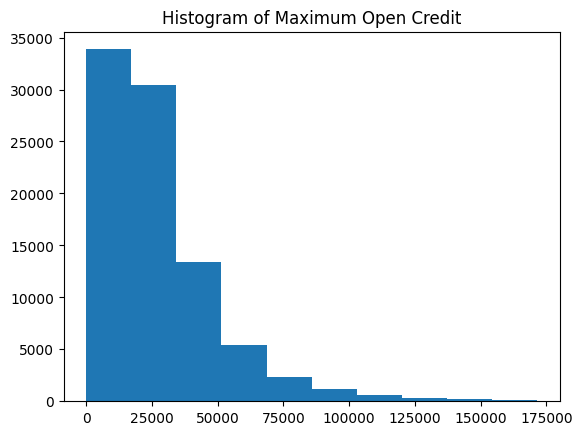

In [90]:
create_histogram(df_agg, 'maximum_open_credit')

In [89]:
df.head()

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
0,6cf51492-02a2-423e-b93d-676f05b9ad53,7c202b37-2add-44e8-9aea-d5b119aea935,Loan Refused,12232,Short Term,7280.0,< 1 year,Rent,46643.0,Debt Consolidation,777.39,18.0,10.0,12,0,6762,7946.0,0.0,0.0
1,552e7ade-4292-4354-9ff9-c48031697d72,e7217b0a-07ac-47dd-b379-577b5a35b7c6,Loan Refused,25014,Long Term,7330.0,10+ years,Home Mortgage,81099.0,Debt Consolidation,892.09,26.7,NaN,14,0,35706,77961.0,0.0,0.0
2,9b5e32b3-8d76-4801-afc8-d729d5a2e6b9,0a62fc41-16c8-40b5-92ff-9e4b763ce714,Loan Refused,16117,Short Term,7240.0,9 years,Home Mortgage,60438.0,Home Improvements,1244.02,16.7,32.0,11,1,11275,14815.0,1.0,0.0
3,5419b7c7-ac11-4be2-a8a7-b131fb6d6dbe,30f36c59-5182-4482-8bbb-5b736849ae43,Loan Refused,11716,Short Term,7400.0,3 years,Rent,34171.0,Debt Consolidation,990.94,10.0,NaN,21,0,7009,43533.0,0.0,0.0
4,1450910f-9495-4fc9-afaf-9bdf4b9821df,70c26012-bba5-42c0-8dcb-75295ada31bb,Loan Refused,9789,Long Term,6860.0,10+ years,Home Mortgage,47003.0,Home Improvements,503.71,16.7,25.0,13,1,16913,19553.0,1.0,0.0


## Multiple variables EDA

For examining the relationship between variables, I will create violin and box plots. First, I will create a function to display the plots side by side, then I'll start examining the 

In [93]:
def create_box_violin_plot(df,x,y):
    fig,axes=plt.subplots(1,2,figsize=(18,10))
    fig.suptitle("Violin and box plots for variable : {}".format(y))
    sns.violinplot(ax=axes[0],x=x,y=y,data=df)
    sns.boxplot(ax=axes[1],data=df[y])

    axes[0].set_title(f"Violin plot for variable {y} and its relation with {x}")
    axes[1].set_title(f"Box plot for variable {y}")
    
    plt.show();

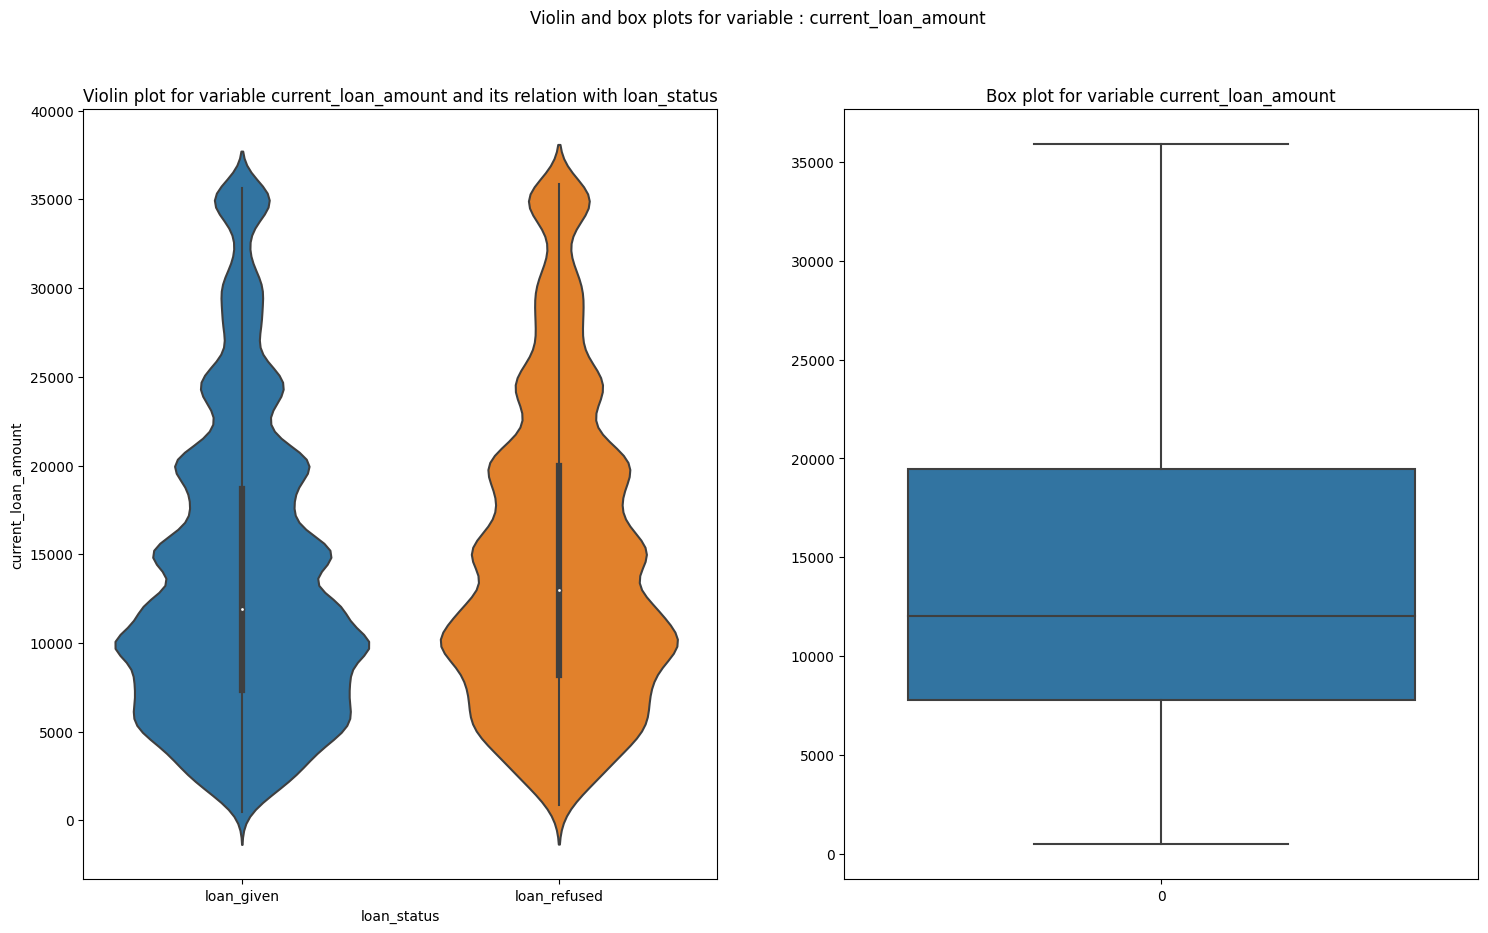

In [94]:
create_box_violin_plot(df_agg, 'loan_status', 'current_loan_amount')

From the box plot, I can see that the outliers are not present. Most people have current loan amount between about 8000 to 19000. 

Next, the violin plot between loan_given and loan_refused is quite identical. This means that visually, there is not a significant difference between the data distribution of current_loan_amount whether the loan is given or refused. This variable might not be a strong predictor of loan status.

Next, I will examine the relationship between term and loan status.

In [131]:
def create_stacked_barcharts(df, x, y):
    # Create non-normalized crosstab
    table = pd.crosstab(df[x], df[y])
    
    # Create a subplot with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot non-normalized stacked bar chart
    colors = plt.cm.tab20.colors
    bottom = [0] * len(table.index)
    
    for idx, category in enumerate(table.columns):
        axes[0].bar(
            table.index,
            table[category],
            bottom=bottom,
            label=category,
            color=colors[idx],
        )
        bottom += table[category]
    
    axes[0].set_ylabel('Frequency')
    axes[0].set_title(f'Stacked Barchart of {x} vs {y} (Non-normalized)')
    axes[0].legend()
    
    # Create normalized crosstab
    normalized_table = pd.crosstab(df[x], df[y], normalize='index')
    
    # Plot normalized stacked bar chart
    bottom = [0] * len(normalized_table.index)
    
    for idx, category in enumerate(normalized_table.columns):
        axes[1].bar(
            normalized_table.index,
            normalized_table[category],
            bottom=bottom,
            label=category,
            color=colors[idx],
        )
        bottom += normalized_table[category]
    
    axes[1].set_ylabel('Percentage')
    axes[1].set_title(f'Stacked Barchart of {x} vs {y} (Normalized)')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    return table, normalized_table

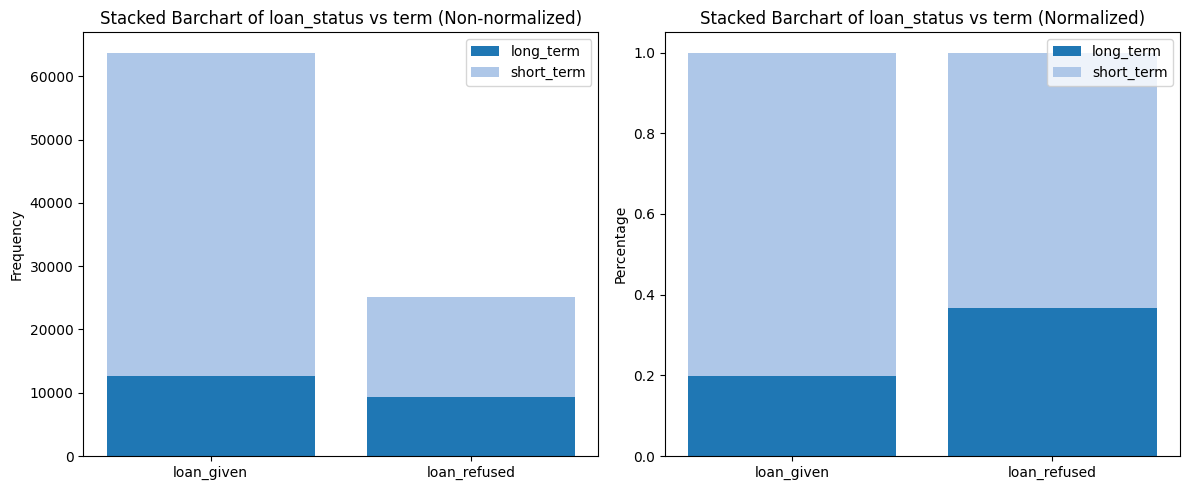

(term          long_term  short_term
 loan_status                        
 loan_given        12714       51023
 loan_refused       9263       15908,
 term          long_term  short_term
 loan_status                        
 loan_given     0.199476    0.800524
 loan_refused   0.368003    0.631997)

In [132]:
create_stacked_barcharts(df_agg,'loan_status', 'term')

The chart indicates that there are significantly more loan given than refused. Moreover short term loans are given more than long term. However, more short term loans are also refused compared to long term ones. Given the differences in proportion, term might be a good predictor of loan_status.

Next, I will move on to credit_score and loan_status.

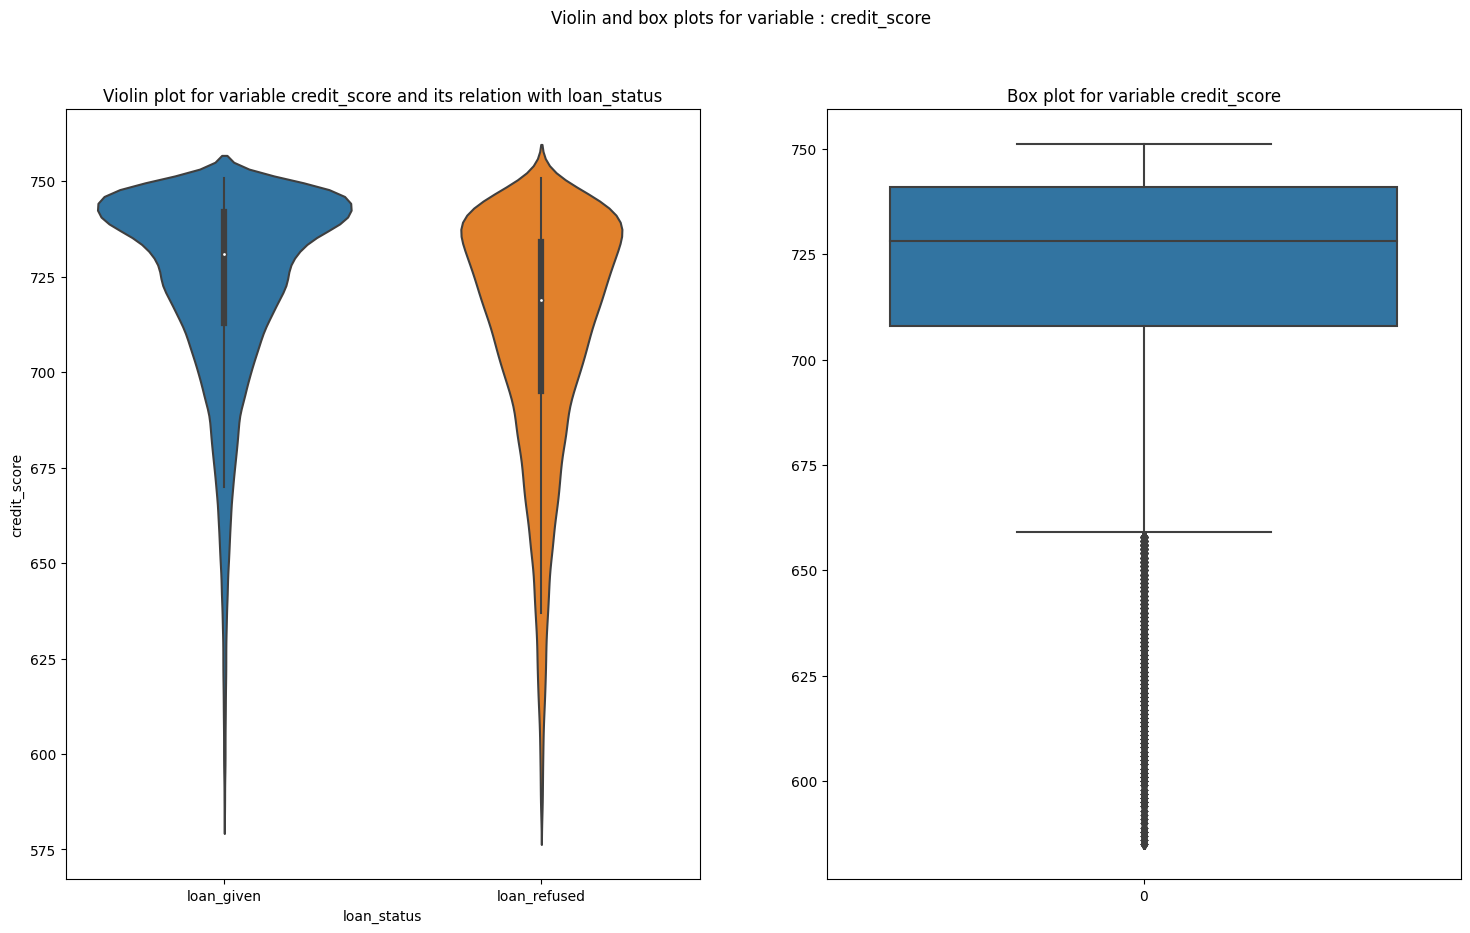

In [102]:
create_box_violin_plot(df_agg, 'loan_status', 'credit_score')

Based on the box plot, most people have between about 710 to 740 credit score. I can see that there are outliers in the data. However, since the outliers are at the bottom and it's still above the lowest amount of credit score (300), I will not clip the data.

The distribution of credit score between the loans that are given and refused seems a bit different. Most people who get the loan have high credit score. However, most people who get the loan refused also have high credit score. Although, we can see that the median of credit score is higher in when the loan is given compared to when the loan is refused. Furthermore, there are a lot more people with lower credit scores who get their loan refused.

This difference in distribution indicates that credit score is a good predictor of whether a loan is given or refused.

I'm interested to see the relationship between credit score and annual income, so I will create a scatter plot for these two variables.

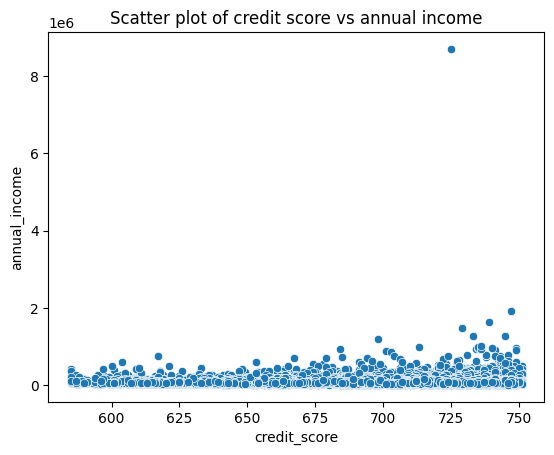

In [111]:
sns.scatterplot(x=df_agg['credit_score'], y=df_agg['annual_income'], data = df_agg)
plt.title('Scatter plot of credit score vs annual income')
plt.show();

There seems to be no relationship between credit score and annual income. It might be because of the outlier. I will remove the outlier and create another scatter plot.

In [107]:
df_scatter = df_agg[df_agg['annual_income'] < df_agg['annual_income'].max()]

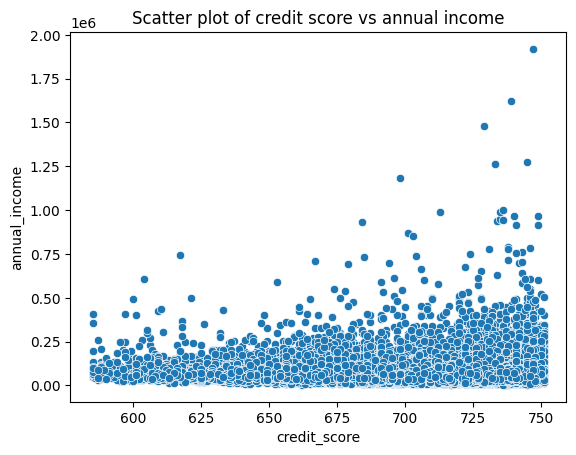

In [109]:
sns.scatterplot(x=df_scatter['credit_score'], y=df_scatter['annual_income'], data = df_scatter)
plt.title('Scatter plot of credit score vs annual income')
plt.show();

In [113]:
correlation = df_scatter['credit_score'].corr(df_scatter['annual_income'])

print(f"Correlation between column1 and column2: {correlation}")

Correlation between column1 and column2: 0.006717951614737181


Based on the plot and the correlation value, there is no relation between credit score and annual income. This means that people with higher credit score do not neccessarily have higher income.

Next, I will see the relationship between years in current job and loan status.

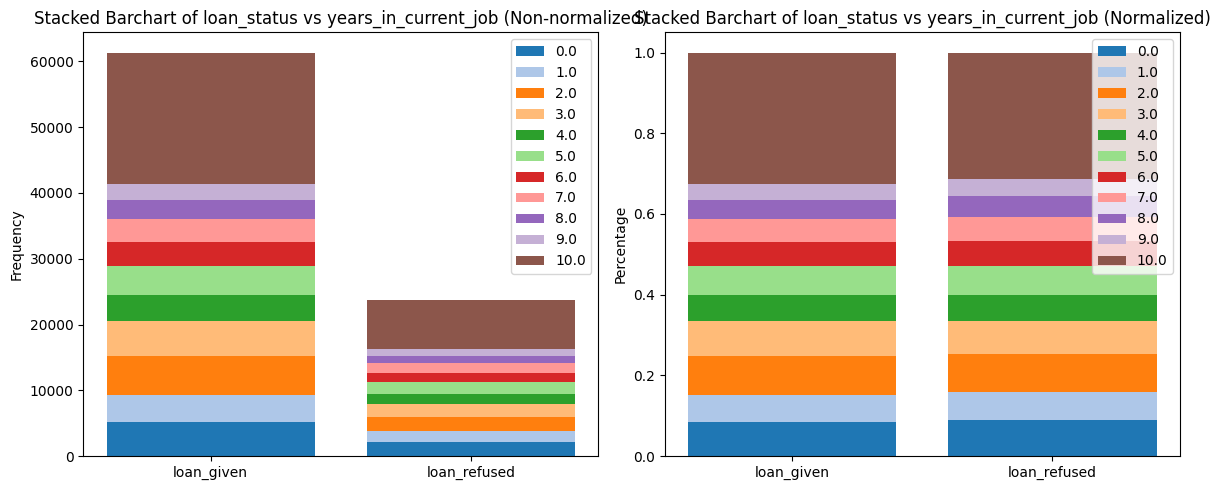

In [134]:
table_years, normalized_table_years = create_stacked_barcharts(df_agg, 'loan_status', 'years_in_current_job')

In [135]:
table_years

years_in_current_job,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
loan_status,,,,,,,,,,,
loan_given,5210,4098,5967,5297,3926,4378,3630,3508,2920,2428,19966
loan_refused,2102,1667,2220,1965,1548,1706,1465,1435,1178,1034,7443


In [136]:
normalized_table_years

years_in_current_job,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
loan_status,,,,,,,,,,,
loan_given,0.084953,0.066821,0.097297,0.086372,0.064016,0.071387,0.05919,0.057201,0.047613,0.039590,0.325561
loan_refused,0.088457,0.070151,0.093423,0.082692,0.065143,0.071792,0.06165,0.060388,0.049573,0.043513,0.313218


Based on the bar chart, more loans are given to people who have worked for more than 10 years. Interestingly, most people who got their loans refused also have worked for 10+ years in their current company. 

The data distribution of years_in_current_job is similar between loan_given and loan_refused. This might mean that there's no relationship between years_in_current_job and loan_status, but more statistical tests are needed to confirm it. 

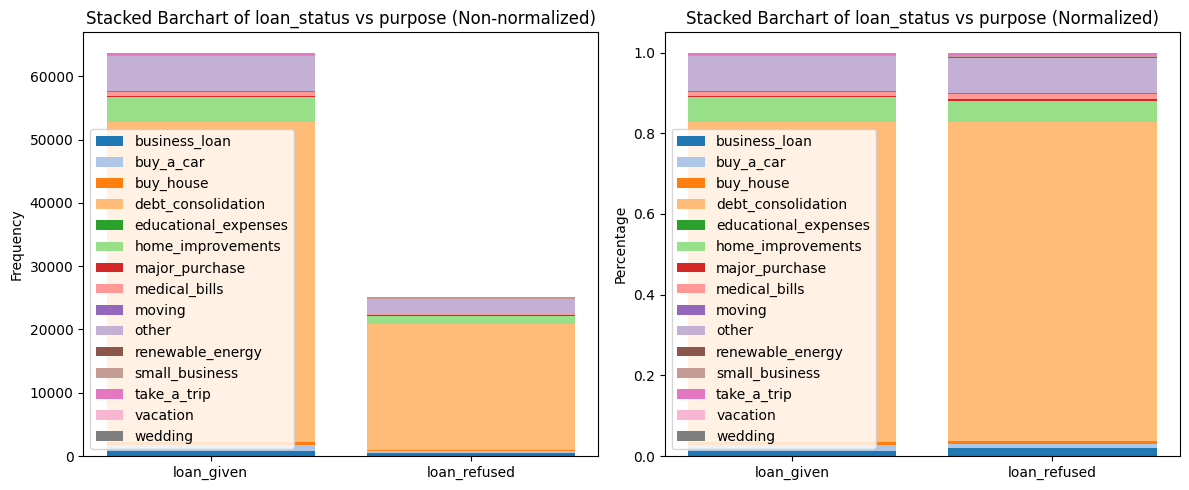

In [138]:
table_purpose, normalized_table_purpose = create_stacked_barcharts(df_agg, 'loan_status', 'purpose')

In [139]:
table_purpose

purpose,business_loan,buy_a_car,buy_house,debt_consolidation,educational_expenses,home_improvements,major_purchase,medical_bills,moving,other,renewable_energy,small_business,take_a_trip,vacation,wedding
loan_status,,,,,,,,,,,,,,,
loan_given,795,962,400,50529,71,3910,245,644,75,5528,5,117,331,52,73
loan_refused,533,234,159,19917,21,1295,99,311,49,2239,4,131,123,30,26


In [140]:
normalized_table_purpose

purpose,business_loan,buy_a_car,buy_house,debt_consolidation,educational_expenses,home_improvements,major_purchase,medical_bills,moving,other,renewable_energy,small_business,take_a_trip,vacation,wedding
loan_status,,,,,,,,,,,,,,,
loan_given,0.012473,0.015093,0.006276,0.792773,0.001114,0.061346,0.003844,0.010104,0.001177,0.086731,0.000078,0.001836,0.005193,0.000816,0.001145
loan_refused,0.021175,0.009296,0.006317,0.791268,0.000834,0.051448,0.003933,0.012355,0.001947,0.088952,0.000159,0.005204,0.004887,0.001192,0.001033
